# Weryfikacja efektywności implementacji metod optymalizacji gradientowej
### Łukasz Knigawka & Grzegorz Kopyt
### 2021L

## Konfiguracja środowiska uruchomieniowego w Google Colab

In [3]:
# Installation cell
%%capture
%%shell
if ! command -v julia 3>&1 > /dev/null
then
    wget -q 'https://julialang-s3.julialang.org/bin/linux/x64/1.6/julia-1.6.0-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz
fi
julia -e 'using Pkg; pkg"add IJulia; precompile;"'
echo 'Done'

Unrecognized magic `%%capture`.

Julia does not use the IPython `%magic` syntax.   To interact with the IJulia kernel, use `IJulia.somefunction(...)`, for example.  Julia macros, string macros, and functions can be used to accomplish most of the other functionalities of IPython magics.


After you run the first cell (the the cell directly above this text), go to Colab's menu bar and select **Edit** and select **Notebook settings** from the drop down. Select *Julia 1.6* in Runtime type. You can also select your prefered harwdware acceleration (defaults to GPU). 

<br/>You should see something like this:

> ![Colab Img](https://raw.githubusercontent.com/Dsantra92/Julia-on-Colab/master/misc/julia_menu.png)

<br/>Click on SAVE
<br/>**We are ready to get going**





In [4]:
VERSION

v"1.6.0"

**The next three cells are for GPU benchmarking. If you are using this notebook for the first time and have GPU enabled, you can give it a try.** 

###GPU Experiments

In [ ]:
using Pkg
Pkg.add(["BenchmarkTools", "CUDA"])
using BenchmarkTools, CUDA

if has_cuda_gpu()
  print("The GPU device is:", CUDA.device())
end

Fetching: [========================================>]  100.0 %.0 %

   Updating registry at `~/.julia/registries/General`
   Updating git-repo `https://github.com/JuliaRegistries/General.git`
  Resolving package versions...
  Installed CEnum ────────── v0.4.1
  Installed TimerOutputs ─── v0.5.9
  Installed BenchmarkTools ─ v1.0.0
  Installed BinaryProvider ─ v0.5.10
  Installed GPUArrays ────── v5.2.1
  Installed LLVM ─────────── v2.0.0
  Installed NNlib ────────── v0.7.17
  Installed CUDA ─────────── v1.3.3
  Installed Requires ─────── v1.1.3
  Installed Adapt ────────── v2.4.0
  Installed ExprTools ────── v0.1.3
  Installed GPUCompiler ──── v0.6.1
  Installed AbstractFFTs ─── v1.0.1
  Installed ChainRulesCore ─ v0.9.45
   Updating `~/.julia/environments/v1.4/Project.toml`
  [6e4b80f9] + BenchmarkTools v1.0.0
  [052768ef] + CUDA v1.3.3
   Updating `~/.julia/environments/v1.4/Manifest.toml`
  [621f4979] + AbstractFFTs v1.0.1
  [79e6a3ab] + Adapt v2.4.0
  [6e4b80f9] + BenchmarkTools v1.0.0
  [b99e7846] + BinaryProvider v0.5.10
  [fa961155] + CEnum v0.4.

In [ ]:
mcpu = rand(2^10, 2^10)
@benchmark mcpu*mcpu

BenchmarkTools.Trial: 
  memory estimate:  8.00 MiB
  allocs estimate:  2
  --------------
  minimum time:     18.179 ms (0.00% GC)
  median time:      22.461 ms (0.00% GC)
  mean time:        24.007 ms (1.62% GC)
  maximum time:     46.888 ms (0.00% GC)
  --------------
  samples:          208
  evals/sample:     1

In [ ]:
println("The CuArray operation should take around 0.5 ms(excluding CUDA downloading time which is a one time process), and should be much faster. If so, the GPU is working.")
mgpu = cu(mcpu)
@benchmark CUDA.@sync mgpu*mgpu

The CuArray operation should take around 0.5 ms(excluding CUDA downloading time which is a one time process), and should be much faster. If so, the GPU is working.


AssertionError: [91mAssertionError: CUDA.jl did not successfully initialize, and is not usable.[39m

# Opis projektu (źródło: isod)

Celem projektu jest zweryfikowanie implementacji algorytmów optymalizacji gradientowej przedstawionych w [1]:

- BFGS,
- L-BFGS (Limited Memory BFGS),
- któryś z: Gradient Descent, RMSprop, Nesterov Momentum, Adam, Adadelta, Adagrad.

W ramach projektu należy ocenić czy możliwa jest bardziej efektywna implementacja tych algorytmów. Polegać to będzie na Przykładowo: dla implementacji w języku Julia należy zadbać m.in. o stabilność typów funkcji, wykorzystanie typów konkretnych w definicji struktur i funkcji. W języku Python niezbędne jest wykorzystanie modułu Numba i ogólna inspekcja kodu LLVM.

Porównaniu powinny podlegać: czas znalezienia rozwiązania (z ustaloną dokładnością ϵ

), liczba potrzebnych iteracji oraz ilość allokowanej pamięci w trakcie działania algorytmu. Przeprowadzone porównanie powinno testować wspominane algorytmy w kilku wariantach: tradycyjnych, dwuwymiarowych funkcji celu jak i wielowymiarowych funkcji celu (co najmniej czterowymiarowych).

Tradycyjne, ciekawe funkcje celu to, np.:

- funkcja Rosenbrocka,
- grzbiet Wheelera (ang. Wheeler’s Ridge function),
- funkcja Michalewicza.

Dobrym przykładem wielowymiarowych funkcji celu jest optymalizacja wag w sieciach neuronowych.

Raport końcowy powinien składać się z czterech części:

1. wstępu precyzującego jakie algorytmy i w jakim języku zostały zaimplementowane;
2. opisu badania, przedstawiającego wybrane przypadki testowe, aspekty porównania oraz (najważniejsze) sposoby i warunki ich pomiaru; w warunkach pomiaru proszę uwzględnić parametry środowiska uruchomieniowego: rozmiar i prędkość pamięci, model procesora, model i typ dysku; niezbędne jest wyszczególnienie wszystkich zastosowanych optymalizacji algorytmów;
3. sekcji z wynikami przedstawionymi w odpowiedniej formie wizualnej;
4. podsumowania, odnoszącego się do wyników, obiektywnie zestawiających cechy charakterystyczne tych algorytmów; należy skonfrontować uzyskane wyniki ze spodziewanymi; warto odnieść się w dyskusji do aspektu związane z implementacją algorytmów.

W raporcie końcowym należy załączyć wykresy prezentujące zbieżność porównywanych algorytmów: najlepiej w postaci narysowanych ścieżek na dwuwymiarowym wykresie z zaznaczoną mapą wysokości testowanej funkcji celu -- tylko dla funkcji dwuwymiarowych. Dla testu funkcji o większej wymiarowości należy zastosować wykres wartości funkcji celu od numeru kroku w skali podwójnie logarytmicznej.

[1]:  Mykel J. Kochenderfer, Tim A. Wheeler, 2019, Algorithms for Optimization, MIT Press.

Sekcje teoretyczne powstają głównie w oparciu o wykład z przedmiotu *Algorytmy w Inżynierii Danych*.

[comment]: # (ponizsze punkty to takie, które wg isod powinny się znaleźć w sprawozdaniu końcowym -- jak zaczniemy tutaj nasze przemyślenia/nawet luźniejsze teksty przyporządkowywać do tych sekcji, to łatwiej będzie to pozbierać w końcowe sprawozdanie)
# Opis problemu

Zadaniem algorytmów optymalizacyjnych jest przeszukanie przestrzeni rozwiązań w celu znalezienia takiego, którego wartość funkcji celu jest najmniejsza.
Aby odnaleźć punkt optymalny, algorytmy optymalizacji mogą polegać na gradiencie i macierzy Hessego (drugich pochodnych) funkcji celu. Optymalizaując wiele parametrów, część z nich może się okazać mało istotna w poszukiwaniu punktu optymalnego. 

Metody pierwszego rzędu opierają się na informacji o gradiencie optymalizowanej funkcji. 


## O czym pamiętać pisząc efektywne algorytmy? (na podstawie Wykładu 08)
Opracowanie powstało, aby zebrać informacje nt. pisania efektywnego kodu w Julii i wiedzę tę wykorzystać przy projekcie. 
- W Julii mamy makro `@time`, które bada czas działania i rozmiar alokowanej pamięci.
- Pakiet `BenchmarTools` posiada makro `@btime`, które wielokrotnie uruchamia kod. Importujemy przy pomocy `import BenchmarkTools: @btime`, następnie w wybranej linijce na początku zawieramy makro. Na przykład `@btime copy_row_col!(out, x);`
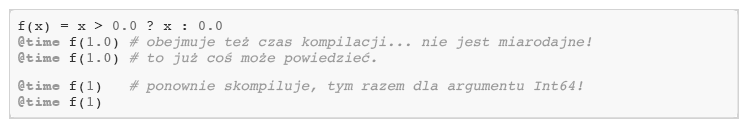
- Gdzie tylko możemy, deklarujmy typu zmiennych/obiektów, nawet jeśli da się to ominąć.
- Domyślnie wycinanie kawałka macierzy tworzy kopię. Rezygnacja z kopiowania na rzecz widoku może przyspieszyć program. Dla wygody możemy skorzystać z makra `@views` , które automatycznie zamienia kopiowanie na
tworzenie widoku. Przykładowe użycie: `@views fview(x) = sum(x[2:end-1]);`.


## Na czym uruchamiamy kod?

In [ ]:
!cat /proc/cpuinfo

LoadError: ignored

In [ ]:
!df -h

LoadError: ignored

## Instalacja bibliotek

In [6]:
using Pkg
Pkg.add(["Plots", "Flux", "PGFPlots", "LinearAlgebra", "LaTeXStrings", "Colors", "ColorSchemes", "Images", "PyPlot", "TikzPictures"])

    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`


In [7]:
import Pkg
Pkg.add(PackageSpec(url="https://github.com/sisl/Vec.jl.git"))

    Updating git-repo `https://github.com/sisl/Vec.jl.git`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`


In [5]:
Pkg.installed()

LoadError: ignored

# Implementacje (kod)
Implemetacje algorytmów zaproponowane w pozycji [1] dostępne są pod [tym](https://github.com/sisl/algforopt-notebooks) adresem.




In [5]:
abstract type DescentMethod end

## Metody pierwszego rzędu



## Adam

Wersja z książki *Algorithms for Optimization*

In [8]:
abstract type DescentMethod end

mutable struct BaseAdam <: DescentMethod
    α       # learning rate
    γv      # update decay
    γs      # gradient decay
    ϵ       # very small value
    k       # step
    v       # 1st moment estimate
    s       # 2nd moment estimate
end

function init!(M::DescentMethod, f, ∇f, x)
    M.k = 0
    M.s = zeros(length(x))
    M.v = zeros(length(x))
    return M
end

function step!(M::DescentMethod, f, ∇f, x)
    α, γv, γs, ϵ, k = M.α, M.γv, M.γs, M.ϵ, M.k
    s, v, g = M.s, M.v, ∇f(x)
    s[:] = γs * s + (1 - γs)*(g .* g)
    v[:] = γv * v + (1 - γv)*g
    M.k = k += 1
    v_hat = v ./ (1 - γv^k)
    s_hat = s ./ (1 - γs^k)
    return x - α*v_hat ./ (sqrt.(s_hat) .+ ϵ)
end

step! (generic function with 1 method)

In [9]:
mutable struct ViewsMockAdam <: DescentMethod
    α     	# learning rate
    γv      # update decay
    γs      # gradient decay
    ϵ       # very small value
    k       # step
    v       # 1st moment estimate
    s       # 2nd moment estimate
end

function init!(M::DescentMethod, f, ∇f, x)
    M.ϵ = 1e-8
    M.s = zeros(length(x))
    M.v = zeros(length(x))
    return M
end

function step!(M::DescentMethod, f, ∇f, x)
    α, γv, γs, ϵ, k = M.α, M.γv, M.γs, M.ϵ, M.k
    s, v, g = M.s, M.v, ∇f(x)
    @views s[:] = γs * s + (1.0 - γs)*(g .* g)
    @views v[:] = γv * v + (1.0 - γv)*g
    M.k = k += 1
    @views v_hat = v ./ (1.0 - γv^k)
    @views s_hat = s ./ (1.0 - γs^k)
    return x - α*v_hat ./ (sqrt.(s_hat) .+ ϵ)
end

function _line_search(f, x, d)
    @views d::Array{Float64, 1} = normalize(d)
    v::Float64, α::Float64 = f(x), 1e-6
    while f(x + α*d) < v
        v = f(x + α*d)
        α += 1e-6
    end
    return x + α*d
end

_line_search (generic function with 1 method)

Wersja z typowaniem

In [10]:
mutable struct TypedAdam <: DescentMethod
    α::Float16     			       # learning rate
    γv::Float64      		       # update decay
    γs::Float64                # gradient decay
    ϵ::Float64                 # very small value
    k::Int32                   # step
    v::Array{Float64, 1}       # 1st moment estimate
    s::Array{Float64, 1}       # 2nd moment estimate
end

function init!(M::DescentMethod, f, ∇f, x)
    M.ϵ = 1e-8
    M.s = zeros(length(x))
    M.v = zeros(length(x))
    return M
end

function step!(M::DescentMethod, f, ∇f, x)
    α, γv, γs, ϵ, k = M.α, M.γv, M.γs, M.ϵ, M.k
    s, v, g = M.s, M.v, ∇f(x)
    @views s[:] = γs * s + (1.0 - γs)*(g .* g)
    @views v[:] = γv * v + (1.0 - γv)*g
    M.k = k += 1
    @views v_hat = v ./ (1.0 - γv^k)
    @views s_hat = s ./ (1.0 - γs^k)
    return x - α*v_hat ./ (sqrt.(s_hat) .+ ϵ)
end

function _line_search(f, x, d)
    @views d::Array{Float64, 1} = normalize(d)
    v::Float64, α::Float64 = f(x), 1e-6
    while f(x + α*d) < v
        v = f(x + α*d)
        α += 1e-6
    end
    return x + α*d
end

_line_search (generic function with 1 method)

Wersja z widokami

Wersja z typowaniem i widokami

## Metody drugiego rzędu


## BFGS

Wersja z książki *Algorithms for Optimization*

In [41]:
using Vec
using LinearAlgebra

function _line_search(f, x, d)
    d = normalize(d)
    objective = α -> f(x + α*d)
    v, α = f(x), 1e-6
    while f(x + α*d) < v
        v = f(x + α*d)
        α += 1e-6
    end
    return x + α*d
end

mutable struct DFP <: DescentMethod
  Q
end
function init!(M::DFP, f, ∇f, x)
  M.Q = Matrix(1.0I, length(x), length(x))
  return M
end
function step!(M::DFP, f, ∇f, x)
  Q, g = M.Q, ∇f(x)
  x′ = _line_search(f, x, -Q*g)
  g′ = ∇f(x′)
  δ = x′ - x
    γ = g′ - g
    Q[:] = Q - Q*γ*γ'*Q/(γ'*Q*γ) + δ*δ'/(δ'*γ)
    return x′
end

mutable struct BaseBFGS <: DescentMethod
  Q
end
function init!(M::BaseBFGS, f, ∇f, x)
  M.Q = Matrix(1.0I, length(x), length(x))
  return M
end
function step!(M::BaseBFGS, f, ∇f, x)
  Q, g = M.Q, ∇f(x)
  x′ = _line_search(f, x, -Q*g)
  g′ = ∇f(x′)
  δ = x′ - x
    γ = g′ - g
    Q[:] = Q - (δ*γ'*Q + Q*γ*δ')/(δ'*γ) + (1 + (γ'*Q*γ)/(δ'*γ))[1]*(δ*δ')/(δ'*γ)
    return x′
end

step! (generic function with 3 methods)

In [73]:
module BasicBFGS
  import ..DescentMethod
  using Vec
  using LinearAlgebra

  function _line_search(f, x, d)
      d = normalize(d)
      objective = α -> f(x + α*d)
      v, α = f(x), 1e-6
      while f(x + α*d) < v
          v = f(x + α*d)
          α += 1e-6
      end
      return x + α*d
  end

  mutable struct DFP <: DescentMethod
    Q
  end
  function init!(M::DFP, f, ∇f, x)
    M.Q = Matrix(1.0I, length(x), length(x))
    return M
  end
  function step!(M::DFP, f, ∇f, x)
    Q, g = M.Q, ∇f(x)
    x′ = _line_search(f, x, -Q*g)
    g′ = ∇f(x′)
    δ = x′ - x
      γ = g′ - g
      Q[:] = Q - Q*γ*γ'*Q/(γ'*Q*γ) + δ*δ'/(δ'*γ)
      return x′
  end

  mutable struct BasicBFGS <: DescentMethod
    Q
  end
  function init!(M::BasicBFGS, f, ∇f, x)
    M.Q = Matrix(1.0I, length(x), length(x))
    return M
  end
  function step!(M::BasicBFGS, f, ∇f, x)
    Q, g = M.Q, ∇f(x)
    x′ = _line_search(f, x, -Q*g)
    g′ = ∇f(x′)
    δ = x′ - x
      γ = g′ - g
      Q[:] = Q - (δ*γ'*Q + Q*γ*δ')/(δ'*γ) + (1 + (γ'*Q*γ)/(δ'*γ))[1]*(δ*δ')/(δ'*γ)
      return x′
  end
end

LoadError: ignored

Wersja z typowaniem

Wersja z widokami

Wersja z typowaniem i widokami

## Limited-memory BFGS

Wersja z książki *Algorithms for Optimization*

In [43]:
mutable struct LimitedMemoryBFGS <: DescentMethod
	m
	δs
	γs
	qs
end
function init!(M::LimitedMemoryBFGS, f, ∇f, x)
	M.δs = []
	M.γs = []
  M.qs = []
	return M
end
function step!(M::LimitedMemoryBFGS, f, ∇f, x)
    δs, γs, qs, g = M.δs, M.γs, M.qs, ∇f(x)
    m = length(δs)
    if m > 0
        q = g
        for i in m : -1 : 1
            qs[i] = copy(q)
            q -= (δs[i]⋅q)/(γs[i]⋅δs[i])*γs[i]
        end
        z = (γs[m] .* δs[m] .* q) / (γs[m]⋅γs[m])
        for i in 1 : m
            z += δs[i]*(δs[i]⋅qs[i] - γs[i]⋅z)/(γs[i]⋅δs[i])
        end
        x′ = _line_search(f, x, -z)
    else
        x′ = _line_search(f, x, -g)
    end
    g′ = ∇f(x′)
    push!(δs, x′ - x); push!(γs, g′ - g)
    push!(qs, zeros(length(x)))
    while length(δs) > M.m
        popfirst!(δs); popfirst!(γs); popfirst!(qs)
    end
    return x′
end

step! (generic function with 4 methods)

Wersja z typowaniem

Wersja z widokami

Wersja z typowaniem i widokami

## Funkcje celu

Te fragmenty kodu generują obrazki z funkcjami :)

In [13]:
using PGFPlots
using Colors
using ColorSchemes
using LinearAlgebra

pasteljet = ColorMaps.RGBArrayMap(ColorSchemes.viridis, interpolation_levels=500, invert=true);
pastelRedBlue = ColorMaps.RGBArrayMap([RGB(246/255, 21/255, 92/255),
                                       RGB(1.0,1.0,1.0),
                                       RGB( 27/255,161/255,234/255)], interpolation_levels=500);
pushPGFPlotsPreamble("\\pgfplotscreateplotcyclelist{pastelcolors}{%")
pushPGFPlotsPreamble("  solid, pastelPurple, mark=none\\\\%")
pushPGFPlotsPreamble("  solid, pastelBlue, mark=none\\\\%")
pushPGFPlotsPreamble("  solid, pastelGreen, mark=none\\\\%")
pushPGFPlotsPreamble("  solid, pastelRed, mark=none\\\\%")
pushPGFPlotsPreamble("  solid, pastelMagenta, mark=none\\\\%")
pushPGFPlotsPreamble("  solid, pastelOrange, mark=none\\\\%")
pushPGFPlotsPreamble("  solid, pastelSeaGreen, mark=none\\\\%")
pushPGFPlotsPreamble("}")
pushPGFPlotsPreamble("\\usepackage{amsmath}")
pushPGFPlotsPreamble("\\usepackage{xfrac}")
pushPGFPlotsPreamble("\\usepgfplotslibrary{fillbetween}")
pushPGFPlotsPreamble("\\usepgfplotslibrary{statistics}")
pushPGFPlotsPreamble("\\definecolor{pastelMagenta}{HTML}{FF48CF}")
pushPGFPlotsPreamble("\\definecolor{pastelPurple}{HTML}{8770FE}")
pushPGFPlotsPreamble("\\definecolor{pastelBlue}{HTML}{1BA1EA}")
pushPGFPlotsPreamble("\\definecolor{pastelSeaGreen}{HTML}{14B57F}")
pushPGFPlotsPreamble("\\definecolor{pastelGreen}{HTML}{3EAA0D}")
pushPGFPlotsPreamble("\\definecolor{pastelOrange}{HTML}{C38D09}")
pushPGFPlotsPreamble("\\definecolor{pastelRed}{HTML}{F5615C}")
pushPGFPlotsPreamble("\\tikzset{myarrow/.style={line width = 0.05cm, ->, rounded corners=5mm}}")
pushPGFPlotsPreamble("\\newcommand{\\vect}[1]{\\boldsymbol{\\mathbf{#1}}}")
pushPGFPlotsPreamble("\\newcommand{\\mat}[1]{\\vect{#1}}")
pushPGFPlotsPreamble("\\pgfplotsset{")
pushPGFPlotsPreamble("   	colormap={pasteljet}{")
pushPGFPlotsPreamble("		rgb=(0.99325,0.90616,0.14394)")
pushPGFPlotsPreamble("		rgb=(0.98387,0.90487,0.13690)")
pushPGFPlotsPreamble("		rgb=(0.97442,0.90359,0.13021)")
pushPGFPlotsPreamble("		rgb=(0.96489,0.90232,0.12394)")
pushPGFPlotsPreamble("		rgb=(0.95530,0.90107,0.11813)")
pushPGFPlotsPreamble("		rgb=(0.94564,0.89982,0.11284)")
pushPGFPlotsPreamble("		rgb=(0.93590,0.89857,0.10813)")
pushPGFPlotsPreamble("		rgb=(0.92611,0.89733,0.10407)")
pushPGFPlotsPreamble("		rgb=(0.91624,0.89609,0.10072)")
pushPGFPlotsPreamble("		rgb=(0.90631,0.89485,0.09813)")
pushPGFPlotsPreamble("		rgb=(0.89632,0.89362,0.09634)")
pushPGFPlotsPreamble("		rgb=(0.88627,0.89237,0.09537)")
pushPGFPlotsPreamble("		rgb=(0.87617,0.89112,0.09525)")
pushPGFPlotsPreamble("		rgb=(0.86601,0.88987,0.09595)")
pushPGFPlotsPreamble("		rgb=(0.85581,0.88860,0.09745)")
pushPGFPlotsPreamble("		rgb=(0.84556,0.88732,0.09970)")
pushPGFPlotsPreamble("		rgb=(0.83527,0.88603,0.10265)")
pushPGFPlotsPreamble("		rgb=(0.82494,0.88472,0.10622)")
pushPGFPlotsPreamble("		rgb=(0.81458,0.88339,0.11035)")
pushPGFPlotsPreamble("		rgb=(0.80418,0.88205,0.11496)")
pushPGFPlotsPreamble("		rgb=(0.79376,0.88068,0.12001)")
pushPGFPlotsPreamble("		rgb=(0.78331,0.87928,0.12540)")
pushPGFPlotsPreamble("		rgb=(0.77285,0.87787,0.13111)")
pushPGFPlotsPreamble("		rgb=(0.76237,0.87642,0.13706)")
pushPGFPlotsPreamble("		rgb=(0.75188,0.87495,0.14323)")
pushPGFPlotsPreamble("		rgb=(0.74139,0.87345,0.14956)")
pushPGFPlotsPreamble("		rgb=(0.73089,0.87192,0.15603)")
pushPGFPlotsPreamble("		rgb=(0.72039,0.87035,0.16260)")
pushPGFPlotsPreamble("		rgb=(0.70990,0.86875,0.16926)")
pushPGFPlotsPreamble("		rgb=(0.69942,0.86712,0.17597)")
pushPGFPlotsPreamble("		rgb=(0.68894,0.86545,0.18272)")
pushPGFPlotsPreamble("		rgb=(0.67849,0.86374,0.18950)")
pushPGFPlotsPreamble("		rgb=(0.66805,0.86200,0.19629)")
pushPGFPlotsPreamble("		rgb=(0.65764,0.86022,0.20308)")
pushPGFPlotsPreamble("		rgb=(0.64726,0.85840,0.20986)")
pushPGFPlotsPreamble("		rgb=(0.63690,0.85654,0.21662)")
pushPGFPlotsPreamble("		rgb=(0.62658,0.85464,0.22335)")
pushPGFPlotsPreamble("		rgb=(0.61629,0.85271,0.23005)")
pushPGFPlotsPreamble("		rgb=(0.60604,0.85073,0.23671)")
pushPGFPlotsPreamble("		rgb=(0.59584,0.84872,0.24333)")
pushPGFPlotsPreamble("		rgb=(0.58568,0.84666,0.24990)")
pushPGFPlotsPreamble("		rgb=(0.57556,0.84457,0.25642)")
pushPGFPlotsPreamble("		rgb=(0.56550,0.84243,0.26288)")
pushPGFPlotsPreamble("		rgb=(0.55548,0.84025,0.26928)")
pushPGFPlotsPreamble("		rgb=(0.54552,0.83804,0.27563)")
pushPGFPlotsPreamble("		rgb=(0.53562,0.83579,0.28191)")
pushPGFPlotsPreamble("		rgb=(0.52578,0.83349,0.28813)")
pushPGFPlotsPreamble("		rgb=(0.51599,0.83116,0.29428)")
pushPGFPlotsPreamble("		rgb=(0.50627,0.82879,0.30036)")
pushPGFPlotsPreamble("		rgb=(0.49661,0.82638,0.30638)")
pushPGFPlotsPreamble("		rgb=(0.48703,0.82393,0.31232)")
pushPGFPlotsPreamble("		rgb=(0.47750,0.82144,0.31820)")
pushPGFPlotsPreamble("		rgb=(0.46805,0.81892,0.32400)")
pushPGFPlotsPreamble("		rgb=(0.45867,0.81636,0.32973)")
pushPGFPlotsPreamble("		rgb=(0.44937,0.81377,0.33538)")
pushPGFPlotsPreamble("		rgb=(0.44014,0.81114,0.34097)")
pushPGFPlotsPreamble("		rgb=(0.43098,0.80847,0.34648)")
pushPGFPlotsPreamble("		rgb=(0.42191,0.80577,0.35191)")
pushPGFPlotsPreamble("		rgb=(0.41291,0.80304,0.35727)")
pushPGFPlotsPreamble("		rgb=(0.40400,0.80027,0.36255)")
pushPGFPlotsPreamble("		rgb=(0.39517,0.79748,0.36776)")
pushPGFPlotsPreamble("		rgb=(0.38643,0.79464,0.37289)")
pushPGFPlotsPreamble("		rgb=(0.37778,0.79178,0.37794)")
pushPGFPlotsPreamble("		rgb=(0.36921,0.78889,0.38291)")
pushPGFPlotsPreamble("		rgb=(0.36074,0.78596,0.38781)")
pushPGFPlotsPreamble("		rgb=(0.35236,0.78301,0.39264)")
pushPGFPlotsPreamble("		rgb=(0.34407,0.78003,0.39738)")
pushPGFPlotsPreamble("		rgb=(0.33588,0.77702,0.40205)")
pushPGFPlotsPreamble("		rgb=(0.32780,0.77398,0.40664)")
pushPGFPlotsPreamble("		rgb=(0.31981,0.77091,0.41115)")
pushPGFPlotsPreamble("		rgb=(0.31193,0.76782,0.41559)")
pushPGFPlotsPreamble("		rgb=(0.30415,0.76470,0.41994)")
pushPGFPlotsPreamble("		rgb=(0.29648,0.76156,0.42422)")
pushPGFPlotsPreamble("		rgb=(0.28892,0.75839,0.42843)")
pushPGFPlotsPreamble("		rgb=(0.28148,0.75520,0.43255)")
pushPGFPlotsPreamble("		rgb=(0.27415,0.75199,0.43660)")
pushPGFPlotsPreamble("		rgb=(0.26694,0.74875,0.44057)")
pushPGFPlotsPreamble("		rgb=(0.25986,0.74549,0.44447)")
pushPGFPlotsPreamble("		rgb=(0.25290,0.74221,0.44828)")
pushPGFPlotsPreamble("		rgb=(0.24607,0.73891,0.45202)")
pushPGFPlotsPreamble("		rgb=(0.23937,0.73559,0.45569)")
pushPGFPlotsPreamble("		rgb=(0.23281,0.73225,0.45928)")
pushPGFPlotsPreamble("		rgb=(0.22640,0.72889,0.46279)")
pushPGFPlotsPreamble("		rgb=(0.22012,0.72551,0.46623)")
pushPGFPlotsPreamble("		rgb=(0.21400,0.72211,0.46959)")
pushPGFPlotsPreamble("		rgb=(0.20803,0.71870,0.47287)")
pushPGFPlotsPreamble("		rgb=(0.20222,0.71527,0.47608)")
pushPGFPlotsPreamble("		rgb=(0.19657,0.71183,0.47922)")
pushPGFPlotsPreamble("		rgb=(0.19109,0.70837,0.48228)")
pushPGFPlotsPreamble("		rgb=(0.18578,0.70489,0.48527)")
pushPGFPlotsPreamble("		rgb=(0.18065,0.70140,0.48819)")
pushPGFPlotsPreamble("		rgb=(0.17571,0.69790,0.49103)")
pushPGFPlotsPreamble("		rgb=(0.17095,0.69438,0.49380)")
pushPGFPlotsPreamble("		rgb=(0.16638,0.69086,0.49650)")
pushPGFPlotsPreamble("		rgb=(0.16202,0.68732,0.49913)")
pushPGFPlotsPreamble("		rgb=(0.15785,0.68376,0.50169)")
pushPGFPlotsPreamble("		rgb=(0.15389,0.68020,0.50417)")
pushPGFPlotsPreamble("		rgb=(0.15015,0.67663,0.50659)")
pushPGFPlotsPreamble("		rgb=(0.14662,0.67305,0.50894)")
pushPGFPlotsPreamble("		rgb=(0.14330,0.66946,0.51121)")
pushPGFPlotsPreamble("		rgb=(0.14021,0.66586,0.51343)")
pushPGFPlotsPreamble("		rgb=(0.13734,0.66225,0.51557)")
pushPGFPlotsPreamble("		rgb=(0.13469,0.65864,0.51765)")
pushPGFPlotsPreamble("		rgb=(0.13227,0.65501,0.51966)")
pushPGFPlotsPreamble("		rgb=(0.13007,0.65138,0.52161)")
pushPGFPlotsPreamble("		rgb=(0.12809,0.64775,0.52349)")
pushPGFPlotsPreamble("		rgb=(0.12633,0.64411,0.52531)")
pushPGFPlotsPreamble("		rgb=(0.12478,0.64046,0.52707)")
pushPGFPlotsPreamble("		rgb=(0.12344,0.63681,0.52876)")
pushPGFPlotsPreamble("		rgb=(0.12231,0.63315,0.53040)")
pushPGFPlotsPreamble("		rgb=(0.12138,0.62949,0.53197)")
pushPGFPlotsPreamble("		rgb=(0.12064,0.62583,0.53349)")
pushPGFPlotsPreamble("		rgb=(0.12008,0.62216,0.53495)")
pushPGFPlotsPreamble("		rgb=(0.11970,0.61849,0.53635)")
pushPGFPlotsPreamble("		rgb=(0.11948,0.61482,0.53769)")
pushPGFPlotsPreamble("		rgb=(0.11942,0.61114,0.53898)")
pushPGFPlotsPreamble("		rgb=(0.11951,0.60746,0.54022)")
pushPGFPlotsPreamble("		rgb=(0.11974,0.60379,0.54140)")
pushPGFPlotsPreamble("		rgb=(0.12009,0.60010,0.54253)")
pushPGFPlotsPreamble("		rgb=(0.12057,0.59642,0.54361)")
pushPGFPlotsPreamble("		rgb=(0.12115,0.59274,0.54464)")
pushPGFPlotsPreamble("		rgb=(0.12183,0.58905,0.54562)")
pushPGFPlotsPreamble("		rgb=(0.12261,0.58537,0.54656)")
pushPGFPlotsPreamble("		rgb=(0.12346,0.58169,0.54744)")
pushPGFPlotsPreamble("		rgb=(0.12440,0.57800,0.54829)")
pushPGFPlotsPreamble("		rgb=(0.12539,0.57432,0.54909)")
pushPGFPlotsPreamble("		rgb=(0.12645,0.57063,0.54984)")
pushPGFPlotsPreamble("		rgb=(0.12757,0.56695,0.55056)")
pushPGFPlotsPreamble("		rgb=(0.12873,0.56327,0.55123)")
pushPGFPlotsPreamble("		rgb=(0.12993,0.55958,0.55186)")
pushPGFPlotsPreamble("		rgb=(0.13117,0.55590,0.55246)")
pushPGFPlotsPreamble("		rgb=(0.13244,0.55222,0.55302)")
pushPGFPlotsPreamble("		rgb=(0.13374,0.54853,0.55354)")
pushPGFPlotsPreamble("		rgb=(0.13507,0.54485,0.55403)")
pushPGFPlotsPreamble("		rgb=(0.13641,0.54117,0.55448)")
pushPGFPlotsPreamble("		rgb=(0.13777,0.53749,0.55491)")
pushPGFPlotsPreamble("		rgb=(0.13915,0.53381,0.55530)")
pushPGFPlotsPreamble("		rgb=(0.14054,0.53013,0.55566)")
pushPGFPlotsPreamble("		rgb=(0.14194,0.52645,0.55599)")
pushPGFPlotsPreamble("		rgb=(0.14334,0.52277,0.55629)")
pushPGFPlotsPreamble("		rgb=(0.14476,0.51909,0.55657)")
pushPGFPlotsPreamble("		rgb=(0.14618,0.51541,0.55682)")
pushPGFPlotsPreamble("		rgb=(0.14761,0.51173,0.55705)")
pushPGFPlotsPreamble("		rgb=(0.14904,0.50805,0.55725)")
pushPGFPlotsPreamble("		rgb=(0.15048,0.50437,0.55743)")
pushPGFPlotsPreamble("		rgb=(0.15192,0.50069,0.55759)")
pushPGFPlotsPreamble("		rgb=(0.15336,0.49700,0.55772)")
pushPGFPlotsPreamble("		rgb=(0.15482,0.49331,0.55784)")
pushPGFPlotsPreamble("		rgb=(0.15627,0.48962,0.55794)")
pushPGFPlotsPreamble("		rgb=(0.15773,0.48593,0.55801)")
pushPGFPlotsPreamble("		rgb=(0.15919,0.48224,0.55807)")
pushPGFPlotsPreamble("		rgb=(0.16067,0.47854,0.55812)")
pushPGFPlotsPreamble("		rgb=(0.16214,0.47484,0.55814)")
pushPGFPlotsPreamble("		rgb=(0.16362,0.47113,0.55815)")
pushPGFPlotsPreamble("		rgb=(0.16512,0.46742,0.55814)")
pushPGFPlotsPreamble("		rgb=(0.16662,0.46371,0.55812)")
pushPGFPlotsPreamble("		rgb=(0.16813,0.45999,0.55808)")
pushPGFPlotsPreamble("		rgb=(0.16965,0.45626,0.55803)")
pushPGFPlotsPreamble("		rgb=(0.17118,0.45253,0.55797)")
pushPGFPlotsPreamble("		rgb=(0.17272,0.44879,0.55788)")
pushPGFPlotsPreamble("		rgb=(0.17427,0.44504,0.55779)")
pushPGFPlotsPreamble("		rgb=(0.17584,0.44129,0.55768)")
pushPGFPlotsPreamble("		rgb=(0.17742,0.43753,0.55756)")
pushPGFPlotsPreamble("		rgb=(0.17902,0.43376,0.55743)")
pushPGFPlotsPreamble("		rgb=(0.18063,0.42997,0.55728)")
pushPGFPlotsPreamble("		rgb=(0.18226,0.42618,0.55712)")
pushPGFPlotsPreamble("		rgb=(0.18390,0.42238,0.55694)")
pushPGFPlotsPreamble("		rgb=(0.18556,0.41857,0.55675)")
pushPGFPlotsPreamble("		rgb=(0.18723,0.41475,0.55655)")
pushPGFPlotsPreamble("		rgb=(0.18892,0.41091,0.55633)")
pushPGFPlotsPreamble("		rgb=(0.19063,0.40706,0.55609)")
pushPGFPlotsPreamble("		rgb=(0.19236,0.40320,0.55584)")
pushPGFPlotsPreamble("		rgb=(0.19410,0.39932,0.55556)")
pushPGFPlotsPreamble("		rgb=(0.19586,0.39543,0.55528)")
pushPGFPlotsPreamble("		rgb=(0.19764,0.39153,0.55497)")
pushPGFPlotsPreamble("		rgb=(0.19943,0.38761,0.55464)")
pushPGFPlotsPreamble("		rgb=(0.20124,0.38367,0.55429)")
pushPGFPlotsPreamble("		rgb=(0.20306,0.37972,0.55393)")
pushPGFPlotsPreamble("		rgb=(0.20490,0.37575,0.55353)")
pushPGFPlotsPreamble("		rgb=(0.20676,0.37176,0.55312)")
pushPGFPlotsPreamble("		rgb=(0.20862,0.36775,0.55268)")
pushPGFPlotsPreamble("		rgb=(0.21050,0.36373,0.55221)")
pushPGFPlotsPreamble("		rgb=(0.21240,0.35968,0.55171)")
pushPGFPlotsPreamble("		rgb=(0.21430,0.35562,0.55118)")
pushPGFPlotsPreamble("		rgb=(0.21621,0.35153,0.55063)")
pushPGFPlotsPreamble("		rgb=(0.21813,0.34743,0.55004)")
pushPGFPlotsPreamble("		rgb=(0.22006,0.34331,0.54941)")
pushPGFPlotsPreamble("		rgb=(0.22199,0.33916,0.54875)")
pushPGFPlotsPreamble("		rgb=(0.22393,0.33499,0.54805)")
pushPGFPlotsPreamble("		rgb=(0.22586,0.33081,0.54731)")
pushPGFPlotsPreamble("		rgb=(0.22780,0.32659,0.54653)")
pushPGFPlotsPreamble("		rgb=(0.22974,0.32236,0.54571)")
pushPGFPlotsPreamble("		rgb=(0.23167,0.31811,0.54483)")
pushPGFPlotsPreamble("		rgb=(0.23360,0.31383,0.54391)")
pushPGFPlotsPreamble("		rgb=(0.23553,0.30953,0.54294)")
pushPGFPlotsPreamble("		rgb=(0.23744,0.30520,0.54192)")
pushPGFPlotsPreamble("		rgb=(0.23935,0.30085,0.54084)")
pushPGFPlotsPreamble("		rgb=(0.24124,0.29648,0.53971)")
pushPGFPlotsPreamble("		rgb=(0.24311,0.29209,0.53852)")
pushPGFPlotsPreamble("		rgb=(0.24497,0.28768,0.53726)")
pushPGFPlotsPreamble("		rgb=(0.24681,0.28324,0.53594)")
pushPGFPlotsPreamble("		rgb=(0.24863,0.27877,0.53456)")
pushPGFPlotsPreamble("		rgb=(0.25043,0.27429,0.53310)")
pushPGFPlotsPreamble("		rgb=(0.25219,0.26978,0.53158)")
pushPGFPlotsPreamble("		rgb=(0.25394,0.26525,0.52998)")
pushPGFPlotsPreamble("		rgb=(0.25565,0.26070,0.52831)")
pushPGFPlotsPreamble("		rgb=(0.25732,0.25613,0.52656)")
pushPGFPlotsPreamble("		rgb=(0.25897,0.25154,0.52474)")
pushPGFPlotsPreamble("		rgb=(0.26057,0.24692,0.52283)")
pushPGFPlotsPreamble("		rgb=(0.26214,0.24229,0.52084)")
pushPGFPlotsPreamble("		rgb=(0.26366,0.23763,0.51876)")
pushPGFPlotsPreamble("		rgb=(0.26515,0.23296,0.51660)")
pushPGFPlotsPreamble("		rgb=(0.26658,0.22826,0.51435)")
pushPGFPlotsPreamble("		rgb=(0.26797,0.22355,0.51201)")
pushPGFPlotsPreamble("		rgb=(0.26931,0.21882,0.50958)")
pushPGFPlotsPreamble("		rgb=(0.27059,0.21407,0.50705)")
pushPGFPlotsPreamble("		rgb=(0.27183,0.20930,0.50443)")
pushPGFPlotsPreamble("		rgb=(0.27301,0.20452,0.50172)")
pushPGFPlotsPreamble("		rgb=(0.27413,0.19972,0.49891)")
pushPGFPlotsPreamble("		rgb=(0.27519,0.19490,0.49600)")
pushPGFPlotsPreamble("		rgb=(0.27619,0.19007,0.49300)")
pushPGFPlotsPreamble("		rgb=(0.27713,0.18523,0.48990)")
pushPGFPlotsPreamble("		rgb=(0.27801,0.18037,0.48670)")
pushPGFPlotsPreamble("		rgb=(0.27883,0.17549,0.48340)")
pushPGFPlotsPreamble("		rgb=(0.27957,0.17060,0.48000)")
pushPGFPlotsPreamble("		rgb=(0.28025,0.16569,0.47650)")
pushPGFPlotsPreamble("		rgb=(0.28087,0.16077,0.47290)")
pushPGFPlotsPreamble("		rgb=(0.28141,0.15583,0.46920)")
pushPGFPlotsPreamble("		rgb=(0.28189,0.15088,0.46541)")
pushPGFPlotsPreamble("		rgb=(0.28229,0.14591,0.46151)")
pushPGFPlotsPreamble("		rgb=(0.28262,0.14093,0.45752)")
pushPGFPlotsPreamble("		rgb=(0.28288,0.13592,0.45343)")
pushPGFPlotsPreamble("		rgb=(0.28307,0.13090,0.44924)")
pushPGFPlotsPreamble("		rgb=(0.28319,0.12585,0.44496)")
pushPGFPlotsPreamble("		rgb=(0.28323,0.12078,0.44058)")
pushPGFPlotsPreamble("		rgb=(0.28320,0.11568,0.43611)")
pushPGFPlotsPreamble("		rgb=(0.28309,0.11055,0.43155)")
pushPGFPlotsPreamble("		rgb=(0.28291,0.10539,0.42690)")
pushPGFPlotsPreamble("		rgb=(0.28266,0.10020,0.42216)")
pushPGFPlotsPreamble("		rgb=(0.28233,0.09495,0.41733)")
pushPGFPlotsPreamble("		rgb=(0.28192,0.08967,0.41241)")
pushPGFPlotsPreamble("		rgb=(0.28145,0.08432,0.40741)")
pushPGFPlotsPreamble("		rgb=(0.28089,0.07891,0.40233)")
pushPGFPlotsPreamble("		rgb=(0.28027,0.07342,0.39716)")
pushPGFPlotsPreamble("		rgb=(0.27957,0.06784,0.39192)")
pushPGFPlotsPreamble("		rgb=(0.27879,0.06214,0.38659)")
pushPGFPlotsPreamble("		rgb=(0.27794,0.05632,0.38119)")
pushPGFPlotsPreamble("		rgb=(0.27702,0.05034,0.37572)")
pushPGFPlotsPreamble("		rgb=(0.27602,0.04417,0.37016)")
pushPGFPlotsPreamble("		rgb=(0.27495,0.03775,0.36454)")
pushPGFPlotsPreamble("		rgb=(0.27381,0.03150,0.35885)")
pushPGFPlotsPreamble("		rgb=(0.27259,0.02556,0.35309)")
pushPGFPlotsPreamble("		rgb=(0.27131,0.01994,0.34727)")
pushPGFPlotsPreamble("		rgb=(0.26994,0.01463,0.34138)")
pushPGFPlotsPreamble("		rgb=(0.26851,0.00961,0.33543)")
pushPGFPlotsPreamble("		rgb=(0.26700,0.00487,0.32942)")
pushPGFPlotsPreamble("	  }")
pushPGFPlotsPreamble("}");

Funkcja Rosenbrocka

In [15]:
p = let
	rosenbrock(x; a=1, b=5) = (a-x[1])^2 + b*(x[2] - x[1]^2)^2

	xdomain = (-2, 2)
	ydomain = (-2, 2)

	plots = PGFPlots.Plot[]
	push!(plots, PGFPlots.Contour(rosenbrock, xdomain, ydomain, levels=[1,2,3,5,10,20,50,100], style="width=\\columnwidth", xbins=100, ybins=100))
	Axis(plots, width="8cm", height="8cm", xlabel=L"x_1", ylabel=L"x_2", style="contour/labels=false, axis equal, view={0}{90}")
end

# PGFPlots.plot(p)

Axis(PGFPlots.Plots.Plot[PGFPlots.Plots.Contour([189.0 186.5839200081624 … 29.81624324048567 29.0; 179.28816161749407 176.93672149439803 … 26.439111994645906 25.68750862290173; … ; 171.44977777911024 169.0983376560142 … 18.600728156262065 17.84912478451789; 181.0 178.5839200081624 … 21.81624324048567 21.0], -2.0:0.04040404040404041:2.0, -2.0:0.04040404040404041:2.0, "width=\\columnwidth", nothing, nothing, [1, 2, 3, 5, 10, 20, 50, 100], nothing, nothing)], nothing, L"$x_1$", nothing, L"$x_2$", nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, "8cm", "8cm", "contour/labels=false, axis equal, view={0}{90}", nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, "axis")

Wheeler

In [16]:
using TikzPictures

p = let
	wheeler(x, a=1.5) = -exp(-(x[1]*x[2] - a)^2 -(x[2]-a)^2)

	xdom = (-8,25)
	ydom = (-3,6)

	Axis(PGFPlots.Image((x,y)->wheeler([x,y]), xdom, ydom, xbins=1200, ybins=480, colormap = pasteljet, colorbar = false),
	     xmin=xdom[1], xmax=xdom[2], ymin=ydom[1], ymax=ydom[2], width="12cm", height="4.8cm", style="view={0}{90}", xlabel=L"x_1", ylabel=L"x_2")
end

# PGFPlots.plot(p)

Axis(PGFPlots.Plots.Plot[PGFPlots.Plots.Image("tmp_10000000000001.png", -8, 25, -3, 6, -0.999823499610959, -0.0, nothing, false, nothing, PGFPlots.ColorMaps.RGBArrayMap(RGB{Float64}[RGB{Float64}(0.993248,0.906157,0.143936), RGB{Float64}(0.983868,0.904867,0.136897), RGB{Float64}(0.974417,0.90359,0.130215), RGB{Float64}(0.964894,0.902323,0.123941), RGB{Float64}(0.9553,0.901065,0.118128), RGB{Float64}(0.945636,0.899815,0.112838), RGB{Float64}(0.935904,0.89857,0.108131), RGB{Float64}(0.926106,0.89733,0.104071), RGB{Float64}(0.916242,0.896091,0.100717), RGB{Float64}(0.906311,0.894855,0.098125)  …  RGB{Float64}(0.277941,0.056324,0.381191), RGB{Float64}(0.277018,0.050344,0.375715), RGB{Float64}(0.276022,0.044167,0.370164), RGB{Float64}(0.274952,0.037752,0.364543), RGB{Float64}(0.273809,0.031497,0.358853), RGB{Float64}(0.272594,0.025563,0.353093), RGB{Float64}(0.271305,0.019942,0.347269), RGB{Float64}(0.269944,0.014625,0.341379), RGB{Float64}(0.26851,0.009605,0.335427), RGB{Float64}(0.267004,0

Michalewicz

In [17]:
p = let
michalewicz(x; m=10) = -sum(sin(v)*sin(i*v^2/π)^(2m) for (i,v) in enumerate(x))

xdomain = (0, 4)
ydomain = (0, 4)

plots = Plots.Plot[]
# push!(plots, Plots.Contour(michalewicz, xdomain, ydomain, levels=[-1.8, -1.6, -1.4, -1.2, -1.0, -0.8, -0.6, -0.4, -0.2], style="width=\\columnwidth", xbins=101, ybins=101))
# Axis(plots, width="8cm", height="8cm", xlabel=L"x_1", ylabel=L"x_2", style="contour/labels=false, axis equal, view={0}{90}")
Axis(PGFPlots.Image((x,y)->michalewicz([x,y]), xdomain, ydomain, xbins=600, ybins=600, colormap = pasteljet, colorbar = false),
xmin=xdomain[1], xmax=xdomain[2], ymin=ydomain[1], ymax=ydomain[2], width="8cm", height="8cm", style="view={0}{90}", xlabel=L"x_1", ylabel=L"x_2")
end

# PGFPlots.plot(p)

Axis(PGFPlots.Plots.Plot[PGFPlots.Plots.Image("tmp_10000000000002.png", 0, 4, 0, 4, -1.8012010742431048, 1.0175243954563755, nothing, false, nothing, PGFPlots.ColorMaps.RGBArrayMap(RGB{Float64}[RGB{Float64}(0.993248,0.906157,0.143936), RGB{Float64}(0.983868,0.904867,0.136897), RGB{Float64}(0.974417,0.90359,0.130215), RGB{Float64}(0.964894,0.902323,0.123941), RGB{Float64}(0.9553,0.901065,0.118128), RGB{Float64}(0.945636,0.899815,0.112838), RGB{Float64}(0.935904,0.89857,0.108131), RGB{Float64}(0.926106,0.89733,0.104071), RGB{Float64}(0.916242,0.896091,0.100717), RGB{Float64}(0.906311,0.894855,0.098125)  …  RGB{Float64}(0.277941,0.056324,0.381191), RGB{Float64}(0.277018,0.050344,0.375715), RGB{Float64}(0.276022,0.044167,0.370164), RGB{Float64}(0.274952,0.037752,0.364543), RGB{Float64}(0.273809,0.031497,0.358853), RGB{Float64}(0.272594,0.025563,0.353093), RGB{Float64}(0.271305,0.019942,0.347269), RGB{Float64}(0.269944,0.014625,0.341379), RGB{Float64}(0.26851,0.009605,0.335427), RGB{Float64

##Metody pomocnicze

In [59]:
  using LinearAlgebra
  import Main.DescentMethod
  import Main.BaseBFGS

  function run_descent_method(M::DescentMethod, x₀, N, f, ∇f)
    pts = [x₀]
    init!(M, f, ∇f, x₀)
    for i in 1 : N
      step!(M, f, ∇f, pts[end])
      push!(pts, step!(M, f, ∇f, pts[end]))
    end
    return 0
  end

  function run_descent_method_plot(M::DescentMethod, x₀, N, f, ∇f)
    pts = [x₀]
    iters = []
    init!(M, f, ∇f, x₀)
    for i in 1 : N
      step!(M, f, ∇f, pts[end])
      push!(pts, step!(M, f, ∇f, pts[end]))
      push!(iters, f(pts[end]))
    end
    println(f(pts[end]))
    return iters
  end

  function test_time(params, x₀, f, ∇f)
    for (M, name, N) in params
      println(name)
      @time pts = run_descent_method(M, x₀, N, f, ∇f)
    end
  end

  function test_time_with_plot(params, x₀, f, ∇f)
    for (M, name, N) in params
      println(name)
      @time pts = run_descent_method_plot(M, x₀, N, f, ∇f)
    end
  end

  function draw_plot(stuff, N, x₀, f, ∇f)
    plt = plot()
    for (M, name, k) in stuff
      println(name)
      iters = run_descent_method_plot(M, x₀, N, f, ∇f)
      plt = plot!(iters, xlabel="Liczba iteracji", ylabel="Wartość funkcji celu",
          label = name)
      display(plt)
      #savefig(path)
    end
  end


draw_plot (generic function with 1 method)

draw_plot (generic function with 1 method)

##Porównanie metod

Testy dla funkcji Rosenbrocka

In [70]:
rosenbrock = x -> (1-x[1])^2 + 100*(4x[2] - x[1]^2)^2
rosenbrock_gradient = x -> [2*(200x[1]^3 - 800x[1]*x[2] + x[1] - 1), -800*(x[1]^2 - 4x[2])]

x₀ = [-2., 1.5]
N = Int32(100000)

tmp = Tuple{DescentMethod, String, Int32}[]

push!(tmp, (BasicBFGS.BFGS(Matrix(1.0I, 2, 2)), "BFGS", 22))
push!(tmp, (BaseBFGS(Matrix(1.0I, 2, 2)), "BFGS", 22))
push!(tmp, (LimitedMemoryBFGS(1, [], [], []), "L-BFGS (m=1)", 22))

# Different variations of Adam optimization

# push!(tmp, (BaseAdam.Adam(0.1, 0.9, 0.8, 1e-8, 0, zeros(2), zeros(2)), "Adam, lr=0.1", 210))
# push!(tmp, (ExtendedAdam.Adam(0.1, 0.9, 0.8, 1e-8, 0, zeros(2), zeros(2)), "Adam, lr=0.1", 210))

test_time(tmp, x₀, rosenbrock, rosenbrock_gradient)
# scoring.draw_plot(tmp, 100, x₀, rosenbrock, rosenbrock_gradient)


BFGS


LoadError: ignored

Testy dla funkcji Michalewicza

In [ ]:
	f = x -> (sin(x[1])*(sin(x[1]^2 / π))^20 + sin(x[2])*(sin(2*(x[2])^2 / π))^20 +
			  sin(x[3])*(sin(3*(x[3])^2 / π))^20 + sin(x[4])*(sin(4*(x[4])^2 / π))^20)

	∇f = x ->  [cos(x[1])*sin(1*(x[1])^2 / π) + sin(x[1])*20*sin(1*x[1]^2 / π)*cos(1*x[1]^2 / π)*2*x[1] / π,
				cos(x[2])*sin(2*(x[2])^2 / π) + sin(x[2])*20*sin(2*x[2]^2 / π)*cos(2*x[2]^2 / π)*4*x[2] / π,
				cos(x[3])*sin(3*(x[3])^2 / π) + sin(x[3])*20*sin(3*x[3]^2 / π)*cos(3*x[3]^2 / π)*6*x[3] / π,
				cos(x[4])*sin(4*(x[4])^2 / π) + sin(x[4])*20*sin(4*x[4]^2 / π)*cos(4*x[4]^2 / π)*8*x[4] / π]

	x₀ = [-0.5, 1.5, -2, 0.5]

	tmp = Tuple{DescentMethod, String, Int16}[]
	push!(tmp, (BFGS(Matrix(1.0I, 2, 2)), "BFGS", 22))
	push!(tmp, (LimitedMemoryBFGS(1, [], [], []), "L-BFGS (m=1)", 8))
	push!(tmp, (Adam(0.1, 0.9, 0.8, 1e-8, 0, zeros(2), zeros(2)), "Adam (lr=0.1)", 210))

  draw_plot(tmp, 100, x₀, f, ∇f)

LoadError: ignored

Testy dla funkcji Wheelera

In [ ]:
	f = x ->   (-exp(-(x[1]*x[2]-3)^2 - (x[2]-3)^2))
	∇f = x ->  [f(x) * (-2*x[2]^2*x[1] + 3*x[2]),
				f(x) * (-2*x[1]^2*x[2] + 3*x[1] - 2*x[2] + 3)]

	x₀ = [0.2, 0.3]
	N = Int(10000)

	tmp = Tuple{DescentMethod, String, Int16}[]
	push!(tmp, (BFGS(Matrix(1.0I, 2, 2)), "BFGS", 198))
	push!(tmp, (LimitedMemoryBFGS(1, [], [], []), "L-BFGS (m=1)", 8))
	push!(tmp, (Adam(0.1, 0.9, 0.8, 1e-8, 0, zeros(2), zeros(2)), "Adam, lr=0.1", 95))


  draw_plot(tmp, 100, x₀, f, ∇f)

LoadError: ignored

## Test

In [ ]:
using PGFPlots
p = let
  # ROSENBROCK 2D
  f = x -> (1-x[1])^2 + 100*(4x[2] - x[1]^2)^2
  ∇f = x -> [2*(200x[1]^3 - 800x[1]*x[2] + x[1] - 1), -800*(x[1]^2 - 4x[2])]
  xdomain = (-2.5, 1.4)
  ydomain = (-0.2, 1.7)
  x₀ = VecE2{Float64}(-2,1.5)
  function this_step!(M::DescentMethod, v::VecE2{Float64})
      x = Float64[v.x, v.y]
      return VecE2{Float64}(step!(M, f, ∇f, x)...)
  end
  function run_descent_method(M::DescentMethod, x₀::VecE2{Float64}, N::Int16)
      pts = [x₀]
      init!(M, f, ∇f, convert(Vector{Float64}, x₀))
      for i in 1 : N
          push!(pts, this_step!(M, pts[end]))
      end
      return pts
  end
  function get_descent_plot(pts::Vector{VecE2{Float64}}, name, color::String="black")
      PGFPlots.Linear([P.x for P in pts], [P.y for P in pts], style="thick,
    $color, solid, mark=none, line join=round", legendentry=name) #$
  end
  stuff = Tuple{DescentMethod, String, String, Int16}[]
  push!(stuff, (BFGS(Matrix(1.0I, 2, 2)), "BFGS", "pastelOrange", 22))
  plots = PGFPlots.Plot[]
  push!(plots, PGFPlots.Contour(f, xdomain, ydomain, levels=[5,50,200,500,1000,2000],
   style="forget plot, width=\\columnwidth", xbins=150, ybins=150))
  for (M, name, color, N) in stuff
      pts = run_descent_method(M, x₀, N)
      push!(plots, get_descent_plot(pts, name, color))
  end
  Axis(plots, width="12cm", height="7cm", xlabel=L"x_1", ylabel=L"x_2",
   style="xtick=\\empty, ytick=\\empty, contour/labels=false, view={0}{90}, legend pos=outer north east")
 end
 PGFPlots.plot(p)

TikzPicture("\\begin{axis}[\n  height = {7cm},\n  ylabel = {\$x_2\$},\n  xlabel = {\$x_1\$},\n  xtick=\\empty, ytick=\\empty, contour/labels=false, view={0}{90}, legend pos=outer north east,\n  width = {12cm}\n]\n\n\\addplot3[\n  contour prepared,\n  forget plot, width=\\columnwidth\n] table {\n  1.4 0.5446453273622712 5.0\n  1.3930139215609165 0.5395973154362416 5.0\n  1.3738255033557047 0.5269518991013521 5.0\n  1.373674718818293 0.5268456375838926 5.0\n  1.3557048531459708 0.5140939597315436 5.0\n  1.3476510067114094 0.5089063007271483 5.0\n  1.336731194042611 0.5013422818791946 5.0\n  1.3214765100671142 0.49162863101158705 5.0\n  1.3169782766889206 0.4885906040268456 5.0\n  1.297054852046277 0.47583892617449663 5.0\n  1.2953020134228188 0.4747491010215418 5.0\n  1.277723224816417 0.46308724832214765 5.0\n  1.2691275167785234 0.4578099608787881 5.0\n  1.2575658358390474 0.45033557046979866 5.0\n  1.2429530201342283 0.4414919631809033 5.0\n  1.236752238301751 0.4375838926174497 5.0\n

TODO
- przygotowanie danych testowych (Pokrycie warunków granicznych - typu min, max, rozbieżność)
- przegląd istniejących algorytmów rozwiązujących problem (odniesienia do aktualnych publikacji z danej dziedziny - Google Scholar!)
- tabele z wynikami eksperymentów (sprawdzić jak się robi takie ładne tabele jak ma malwina)
- kod z zastosowaniem typowania 
- pomiary alokowanej pamięci
- postawienie tezy gdzieś na początku sprawka i potwierdzenie tezy na końcu
- wykresy wartości funkcji celu w zależności od iteracji (wykresy)
- odległość od minimum globalnego (wykresy)
- zbieżność optymalizatorów (wykresy)
- zastosowanie makra @views
- podsumowanie = 4/5 zdań!